### Training Logs

https://wandb.ai/ahmadjaved97/trinet_model?nw=nwuserahmadjaved97

In [1]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models

import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

### Data Loading and Processing

In [4]:
def build_people_dict(csv_path, root_dir):
    """
    This function takes the CSV file and creates a dictionary of file paths corresponding to each person in the CSV file.
    """
    df = pd.read_csv(csv_path)
    people_dict = defaultdict(list)
    
    for idx, row in df.iterrows():
        person_name = row['name']
        num_images_expected = row['images']
        
        # Get full folder path
        person_folder = os.path.join(root_dir, person_name)
        
        file_extensions = ('.jpg', '.jpeg', '.png')
        if os.path.exists(person_folder):
            image_files = []
            for file in os.listdir(person_folder):
                if file.endswith(file_extensions):
                    image_files.append(file)
                image_files = sorted(image_files)
    
                # Build the full paths for the images
                full_paths = [os.path.join(person_folder, img_file) for img_file in image_files]
                
                people_dict[person_name].extend(full_paths)
        else:
            print(f"No folder found for person: {person_name}")
    
    return dict(people_dict)

In [5]:
train_csv = "/home/user/javeda1/lwf_dataset/peopleDevTrain.csv"
test_csv = "/home/user/javeda1/lwf_dataset/peopleDevTest.csv"
root_dir = "/home/user/javeda1/lwf_datasets"  # Folder containing image subfolders

people_dict_train = build_people_dict(train_csv, root_dir)
people_dict_test = build_people_dict(test_csv, root_dir)

In [6]:
class LFWDataset(Dataset):
    def __init__(self, people_dict, transform=None, num_samples=10000):
        self.people_dict = people_dict
        self.person_ids = list(people_dict.keys())
        self.transform = transform
        self.num_samples = num_samples
        
        self.label2id = {person: idx for idx, person in enumerate(self.person_ids)}

    def __len__(self):
        return len(self.people_dict)

    def __getitem__(self, idx):
        # Sample a random person for the anchor
        anchor_person = random.choice(self.person_ids)
        
        # Get positive and negative anchors
        if len(self.people_dict[anchor_person]) < 2:
            # Recursively call the function until an anchor person with >= 2 images is found
            return self.__getitem__(random.randint(0, self.num_samples - 1))
        
        anchor_path, positive_path = random.sample(self.people_dict[anchor_person], 2)
        
        negative_person = random.choice(self.person_ids)
        # Again while loop till a different person is found.
        while negative_person == anchor_person or len(self.people_dict[negative_person]) < 1:
            negative_person = random.choice(self.person_ids)
        negative_path = random.choice(self.people_dict[negative_person])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)


        anchor_label = self.label2id[anchor_person]
        positive_label = anchor_label
        negative_label = self.label2id[negative_person]

        return anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [8]:
# Create the Datasets
train_dataset = LFWDataset(people_dict_train, transform=train_transform)
test_dataset = LFWDataset(people_dict_test, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### Visualize Dataset

In [9]:
def minmax_normalize(tensor):
    # Min-max normalization
    tensor_min, tensor_max = tensor.min(), tensor.max()
    return (tensor - tensor_min) / (tensor_max - tensor_min)


def visualize_triplet_samples(dataset, n=5):
    """
    Visualize n samples from the TripletDataset using Min-Max normalization.
    """

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 3*n))

    for i in range(n):
        # Fetch one item
        anchor, positive, negative, _, _, _ = dataset[i]

        # Apply Min-Max normalization
        anchor_disp = minmax_normalize(anchor)
        positive_disp = minmax_normalize(positive)
        negative_disp = minmax_normalize(negative)

        anchor_np = anchor_disp.permute(1, 2, 0).cpu().numpy()
        positive_np = positive_disp.permute(1, 2, 0).cpu().numpy()
        negative_np = negative_disp.permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(anchor_np)
        axes[i, 1].imshow(positive_np)
        axes[i, 2].imshow(negative_np)
        
        axes[i, 0].set_title("Anchor")
        axes[i, 1].set_title("Positive")
        axes[i, 2].set_title("Negative")
        
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

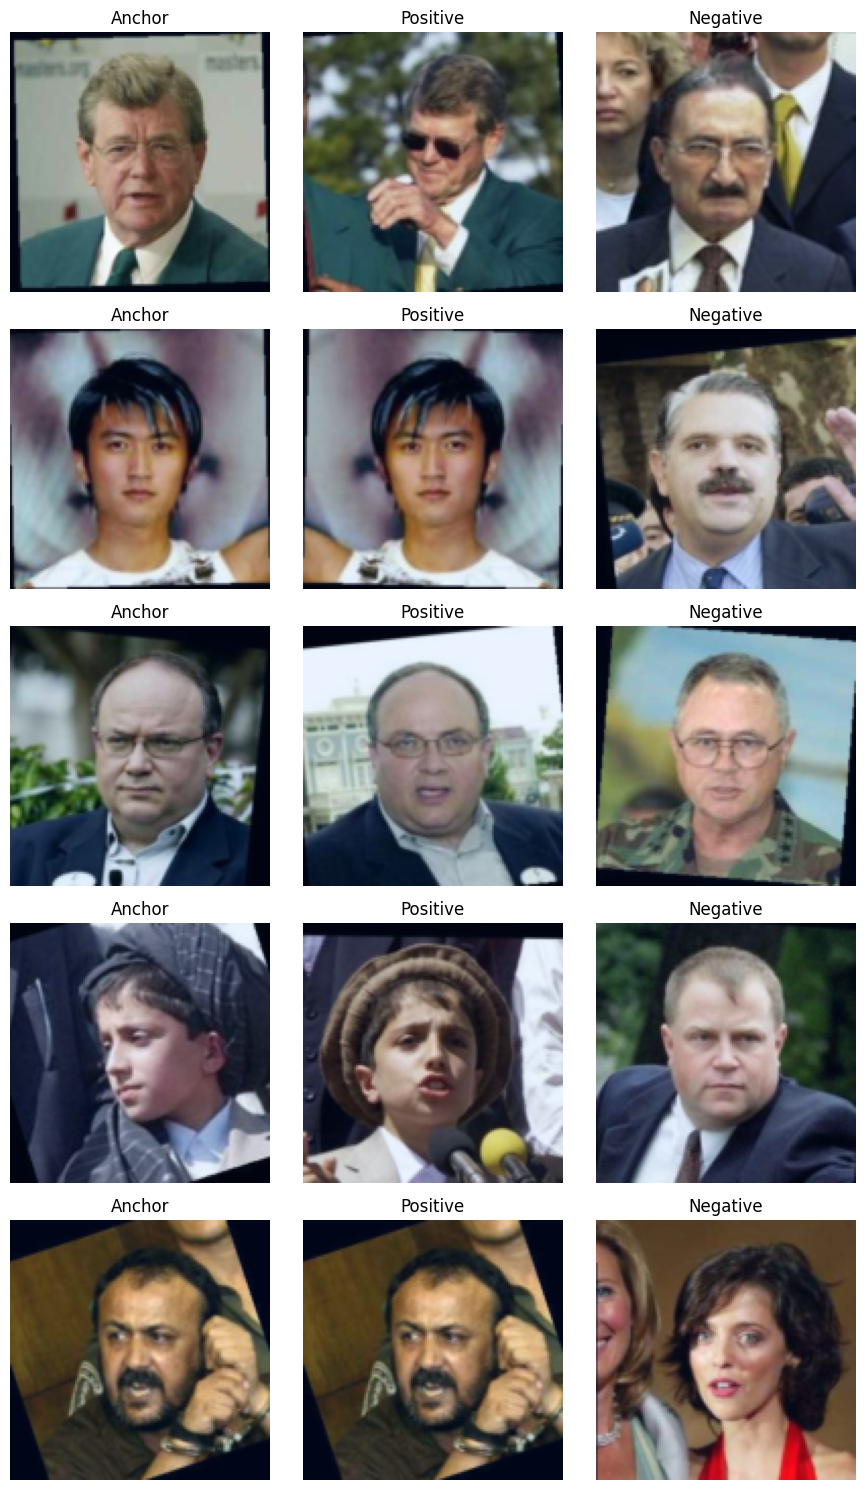

In [10]:
visualize_triplet_samples(train_dataset, n=5)

### Model architecture

In [11]:
class TriNet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained=True):
        super(TriNet, self).__init__()
        #ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Remove the last FC
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        
        return x

### Training Code

In [12]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Trains the model for one epoch """
    model.train()
    running_loss = 0.0
    
    for anchor, positive, negative, _, _,_ in dataloader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_emb   = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def eval_one_epoch(model, dataloader, loss_fn, device):
    """Evaluates the model after each epoch."""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative, _, _, _ in dataloader:
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_emb   = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def train(model, train_dataloader, val_dataloader, optimizer,
          device, epochs=10, margin=0.5,
         project="my_trinet-project", name='test_run-1'):

    
    # Initialize W&B
    wandb.init(project=project, name=name, config={
        "epochs": epochs,
        "margin": margin,
        "learning_rate": optimizer.param_groups[0]["lr"]
    })

    # triplet loss
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, triplet_loss_fn, device)
        val_loss   = eval_one_epoch(model, val_dataloader, triplet_loss_fn, device)
        
        #learning rate
        current_lr = optimizer.param_groups[0]["lr"]

        # Log metrics to wandb
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": current_lr,
            "epoch": epoch + 1
        })

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Finish wandb run
    wandb.finish()

    return model

### Load Model

In [13]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

### Compute ARI for the trained models

In [14]:
def get_top_k_people(people_dict, k=10):
    """
    Returns a list of the k person_ids that have the most images.
    """
    counts = [(len(paths), person) for person, paths in people_dict.items()]
    
    # Sort descending
    counts.sort(reverse=True, key=lambda x: x[0])
    top_k_people = [person for (count, person) in counts[:k]]
    
    return top_k_people

In [15]:
def gather_images_labels_topk(people_dict, top_k_people, transform=None):
    """
    Collects image_tensors, labels for just the top_k_people.
    """
    label2id = {person: idx for idx, person in enumerate(top_k_people)}
    
    all_images = []
    all_labels = []
    
    for person in top_k_people:
        paths = people_dict[person]
        label = label2id[person]
        for img_path in paths:
            img = Image.open(img_path).convert("RGB")
            if transform:
                img = transform(img)
            all_images.append(img)
            all_labels.append(label)
    
    return all_images, all_labels, label2id

In [16]:
def gather_images_and_labels(dataset, num_samples=1000):
    
    all_imgs = []
    all_labels = []
    
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    chosen_indices = indices[:num_samples]

    for idx in chosen_indices:
        anchor_img, positive_img, negative_img, anchor_lbl, positive_lbl, negative_lbl = dataset[idx]

        all_imgs.append(anchor_img)
        all_labels.append(anchor_lbl)

    return all_imgs, all_labels

In [17]:
def compute_embeddings(model, images, labels, device):
    """
    Compute embeddings for a list of image tensors.
    """
    model.eval()
    embeddings_list = []
    labels = np.array(labels)

    with torch.no_grad():
        for img_tensor in images:
            img_tensor = img_tensor.unsqueeze(0).to(device)
            emb = model(img_tensor)
            embeddings_list.append(emb.cpu())

    embeddings = torch.cat(embeddings_list, dim=0).numpy()

    return embeddings, labels

In [18]:
def compute_ari_from_embeddings(embeddings, labels, device):
    """
    Compute's ARI from the embeddings
    """

    # embeddings, labels = compute_embeddings(model, images, labels, device)

    # K-Means
    all_labels = np.array(labels)
    unique_labels = np.unique(all_labels)
    n_clusters = len(unique_labels)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(embeddings)

    # ARI
    ari = adjusted_rand_score(all_labels, cluster_assignments)
    return ari

In [19]:
def visualize_embeddings_2D(embeddings, labels, id2label=None, method="pca"):
    """
    Visualize embeddings using PCA or TSNE.
    """
    if method == "pca":
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
        title = "PCA"
    elif method == "tsne":
        reducer = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
        reduced = reducer.fit_transform(embeddings)
        title = "t-SNE"
    else:
        raise ValueError("method should be 'pca' or 'tsne'")

    plt.figure(figsize=(14, 12))
    unique_labels = np.unique(labels)

    for lab in unique_labels:
        idx = (labels == lab)
        # maps to names if mapping dicitionary is present else puts class numbers
        legend_label = id2label[lab] if id2label is not None else f"Class {lab}"
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=legend_label, alpha=0.7)
    
    plt.legend(loc="best")
    plt.title(f"2D Embeddings -- {title}")
    plt.show()

### Model Training

#### 1. margin = 0.1

In [20]:
# Paramters
margin=0.1
epochs=50
project='trinet_model'
name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  2%|█                                                       | 1/50 [00:20<16:48, 20.58s/it]

Epoch [1/50] Train Loss: 0.0257 | Val Loss: 0.0231 | LR: 0.000100


  4%|██▏                                                     | 2/50 [00:40<16:15, 20.33s/it]

Epoch [2/50] Train Loss: 0.0130 | Val Loss: 0.0158 | LR: 0.000100


  6%|███▎                                                    | 3/50 [01:01<15:59, 20.42s/it]

Epoch [3/50] Train Loss: 0.0089 | Val Loss: 0.0155 | LR: 0.000100


  8%|████▍                                                   | 4/50 [01:21<15:34, 20.32s/it]

Epoch [4/50] Train Loss: 0.0088 | Val Loss: 0.0149 | LR: 0.000100


 10%|█████▌                                                  | 5/50 [01:41<15:08, 20.18s/it]

Epoch [5/50] Train Loss: 0.0081 | Val Loss: 0.0138 | LR: 0.000100


 12%|██████▋                                                 | 6/50 [02:01<14:45, 20.13s/it]

Epoch [6/50] Train Loss: 0.0064 | Val Loss: 0.0147 | LR: 0.000100


 14%|███████▊                                                | 7/50 [02:21<14:24, 20.11s/it]

Epoch [7/50] Train Loss: 0.0060 | Val Loss: 0.0114 | LR: 0.000100


 16%|████████▉                                               | 8/50 [02:41<14:03, 20.09s/it]

Epoch [8/50] Train Loss: 0.0058 | Val Loss: 0.0133 | LR: 0.000100


 18%|██████████                                              | 9/50 [03:01<13:48, 20.22s/it]

Epoch [9/50] Train Loss: 0.0059 | Val Loss: 0.0113 | LR: 0.000100


 20%|███████████                                            | 10/50 [03:22<13:29, 20.23s/it]

Epoch [10/50] Train Loss: 0.0043 | Val Loss: 0.0122 | LR: 0.000100


 22%|████████████                                           | 11/50 [03:42<13:06, 20.18s/it]

Epoch [11/50] Train Loss: 0.0049 | Val Loss: 0.0140 | LR: 0.000100


 24%|█████████████▏                                         | 12/50 [04:02<12:44, 20.13s/it]

Epoch [12/50] Train Loss: 0.0056 | Val Loss: 0.0122 | LR: 0.000100


 26%|██████████████▎                                        | 13/50 [04:22<12:25, 20.14s/it]

Epoch [13/50] Train Loss: 0.0050 | Val Loss: 0.0118 | LR: 0.000100


 28%|███████████████▍                                       | 14/50 [04:42<12:06, 20.17s/it]

Epoch [14/50] Train Loss: 0.0051 | Val Loss: 0.0125 | LR: 0.000100


 30%|████████████████▌                                      | 15/50 [05:02<11:44, 20.14s/it]

Epoch [15/50] Train Loss: 0.0038 | Val Loss: 0.0096 | LR: 0.000100


 32%|█████████████████▌                                     | 16/50 [05:22<11:22, 20.08s/it]

Epoch [16/50] Train Loss: 0.0039 | Val Loss: 0.0104 | LR: 0.000100


 34%|██████████████████▋                                    | 17/50 [05:42<11:02, 20.07s/it]

Epoch [17/50] Train Loss: 0.0038 | Val Loss: 0.0120 | LR: 0.000100


 36%|███████████████████▊                                   | 18/50 [06:02<10:41, 20.05s/it]

Epoch [18/50] Train Loss: 0.0045 | Val Loss: 0.0121 | LR: 0.000100


 38%|████████████████████▉                                  | 19/50 [06:22<10:21, 20.06s/it]

Epoch [19/50] Train Loss: 0.0049 | Val Loss: 0.0118 | LR: 0.000100


 40%|██████████████████████                                 | 20/50 [06:42<10:02, 20.07s/it]

Epoch [20/50] Train Loss: 0.0040 | Val Loss: 0.0084 | LR: 0.000100


 42%|███████████████████████                                | 21/50 [07:03<09:41, 20.07s/it]

Epoch [21/50] Train Loss: 0.0040 | Val Loss: 0.0114 | LR: 0.000100


 44%|████████████████████████▏                              | 22/50 [07:23<09:22, 20.08s/it]

Epoch [22/50] Train Loss: 0.0036 | Val Loss: 0.0084 | LR: 0.000100


 46%|█████████████████████████▎                             | 23/50 [07:43<09:02, 20.10s/it]

Epoch [23/50] Train Loss: 0.0034 | Val Loss: 0.0099 | LR: 0.000100


 48%|██████████████████████████▍                            | 24/50 [08:03<08:42, 20.09s/it]

Epoch [24/50] Train Loss: 0.0037 | Val Loss: 0.0086 | LR: 0.000100


 50%|███████████████████████████▌                           | 25/50 [08:23<08:22, 20.11s/it]

Epoch [25/50] Train Loss: 0.0042 | Val Loss: 0.0121 | LR: 0.000100


 52%|████████████████████████████▌                          | 26/50 [08:43<08:02, 20.10s/it]

Epoch [26/50] Train Loss: 0.0032 | Val Loss: 0.0104 | LR: 0.000100


 54%|█████████████████████████████▋                         | 27/50 [09:03<07:41, 20.08s/it]

Epoch [27/50] Train Loss: 0.0036 | Val Loss: 0.0108 | LR: 0.000100


 56%|██████████████████████████████▊                        | 28/50 [09:23<07:22, 20.09s/it]

Epoch [28/50] Train Loss: 0.0040 | Val Loss: 0.0105 | LR: 0.000100


 58%|███████████████████████████████▉                       | 29/50 [09:43<07:02, 20.11s/it]

Epoch [29/50] Train Loss: 0.0038 | Val Loss: 0.0098 | LR: 0.000100


 60%|█████████████████████████████████                      | 30/50 [10:03<06:41, 20.09s/it]

Epoch [30/50] Train Loss: 0.0036 | Val Loss: 0.0076 | LR: 0.000100


 62%|██████████████████████████████████                     | 31/50 [10:24<06:21, 20.09s/it]

Epoch [31/50] Train Loss: 0.0029 | Val Loss: 0.0092 | LR: 0.000100


 64%|███████████████████████████████████▏                   | 32/50 [10:44<06:01, 20.08s/it]

Epoch [32/50] Train Loss: 0.0026 | Val Loss: 0.0096 | LR: 0.000100


 66%|████████████████████████████████████▎                  | 33/50 [11:04<05:41, 20.10s/it]

Epoch [33/50] Train Loss: 0.0030 | Val Loss: 0.0090 | LR: 0.000100


 68%|█████████████████████████████████████▍                 | 34/50 [11:24<05:21, 20.11s/it]

Epoch [34/50] Train Loss: 0.0027 | Val Loss: 0.0074 | LR: 0.000100


 70%|██████████████████████████████████████▌                | 35/50 [11:44<05:01, 20.12s/it]

Epoch [35/50] Train Loss: 0.0027 | Val Loss: 0.0096 | LR: 0.000100


 72%|███████████████████████████████████████▌               | 36/50 [12:04<04:41, 20.11s/it]

Epoch [36/50] Train Loss: 0.0034 | Val Loss: 0.0082 | LR: 0.000100


 74%|████████████████████████████████████████▋              | 37/50 [12:24<04:20, 20.07s/it]

Epoch [37/50] Train Loss: 0.0030 | Val Loss: 0.0087 | LR: 0.000100


 76%|█████████████████████████████████████████▊             | 38/50 [12:44<04:00, 20.02s/it]

Epoch [38/50] Train Loss: 0.0025 | Val Loss: 0.0100 | LR: 0.000100


 78%|██████████████████████████████████████████▉            | 39/50 [13:04<03:39, 19.99s/it]

Epoch [39/50] Train Loss: 0.0028 | Val Loss: 0.0109 | LR: 0.000100


 80%|████████████████████████████████████████████           | 40/50 [13:24<03:20, 20.02s/it]

Epoch [40/50] Train Loss: 0.0025 | Val Loss: 0.0098 | LR: 0.000100


 82%|█████████████████████████████████████████████          | 41/50 [13:44<03:00, 20.04s/it]

Epoch [41/50] Train Loss: 0.0023 | Val Loss: 0.0103 | LR: 0.000100


 84%|██████████████████████████████████████████████▏        | 42/50 [14:04<02:40, 20.01s/it]

Epoch [42/50] Train Loss: 0.0025 | Val Loss: 0.0095 | LR: 0.000100


 86%|███████████████████████████████████████████████▎       | 43/50 [14:24<02:19, 19.99s/it]

Epoch [43/50] Train Loss: 0.0033 | Val Loss: 0.0089 | LR: 0.000100


 88%|████████████████████████████████████████████████▍      | 44/50 [14:44<01:59, 20.00s/it]

Epoch [44/50] Train Loss: 0.0027 | Val Loss: 0.0085 | LR: 0.000100


 90%|█████████████████████████████████████████████████▌     | 45/50 [15:04<01:40, 20.01s/it]

Epoch [45/50] Train Loss: 0.0029 | Val Loss: 0.0105 | LR: 0.000100


 92%|██████████████████████████████████████████████████▌    | 46/50 [15:24<01:19, 19.98s/it]

Epoch [46/50] Train Loss: 0.0032 | Val Loss: 0.0127 | LR: 0.000100


 94%|███████████████████████████████████████████████████▋   | 47/50 [15:44<00:59, 19.96s/it]

Epoch [47/50] Train Loss: 0.0029 | Val Loss: 0.0104 | LR: 0.000100


 96%|████████████████████████████████████████████████████▊  | 48/50 [16:04<00:39, 19.97s/it]

Epoch [48/50] Train Loss: 0.0026 | Val Loss: 0.0075 | LR: 0.000100


 98%|█████████████████████████████████████████████████████▉ | 49/50 [16:24<00:19, 19.99s/it]

Epoch [49/50] Train Loss: 0.0028 | Val Loss: 0.0063 | LR: 0.000100


100%|███████████████████████████████████████████████████████| 50/50 [16:44<00:00, 20.09s/it]

Epoch [50/50] Train Loss: 0.0032 | Val Loss: 0.0089 | LR: 0.000100


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▄▃▃▄▃▃▂▂▃▃▁▃▁▂▃▂▂▂▂▂▂▁▂▁▂▃▂▂▂▂▃▂▁▂
epoch,50
learning_rate,0.0001
train_loss,0.00322
val_loss,0.00891


Model saved at: ./saved_models/margin_0.1_ep_50


In [22]:
all_imgs, all_labels = gather_images_and_labels(dataset=test_dataset, num_samples=5000)

In [23]:
# Get top-k people based on number of images.
top_k_people = get_top_k_people(people_dict_test, k=10)
top_k_people

['Donald_Rumsfeld',
 'Gerhard_Schroeder',
 'Jacques_Chirac',
 'Jennifer_Capriati',
 'Alvaro_Uribe',
 'Silvio_Berlusconi',
 'Kofi_Annan',
 'Vicente_Fox',
 'John_Negroponte',
 'Mahmoud_Abbas']

In [23]:
# Compute embeddings
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)

In [24]:
ari_value = compute_ari_from_embeddings(embeddings, labels, device)
print(f"Adjusted Rand Index (ARI): {ari_value:.4f}")

Adjusted Rand Index (ARI): 0.4590


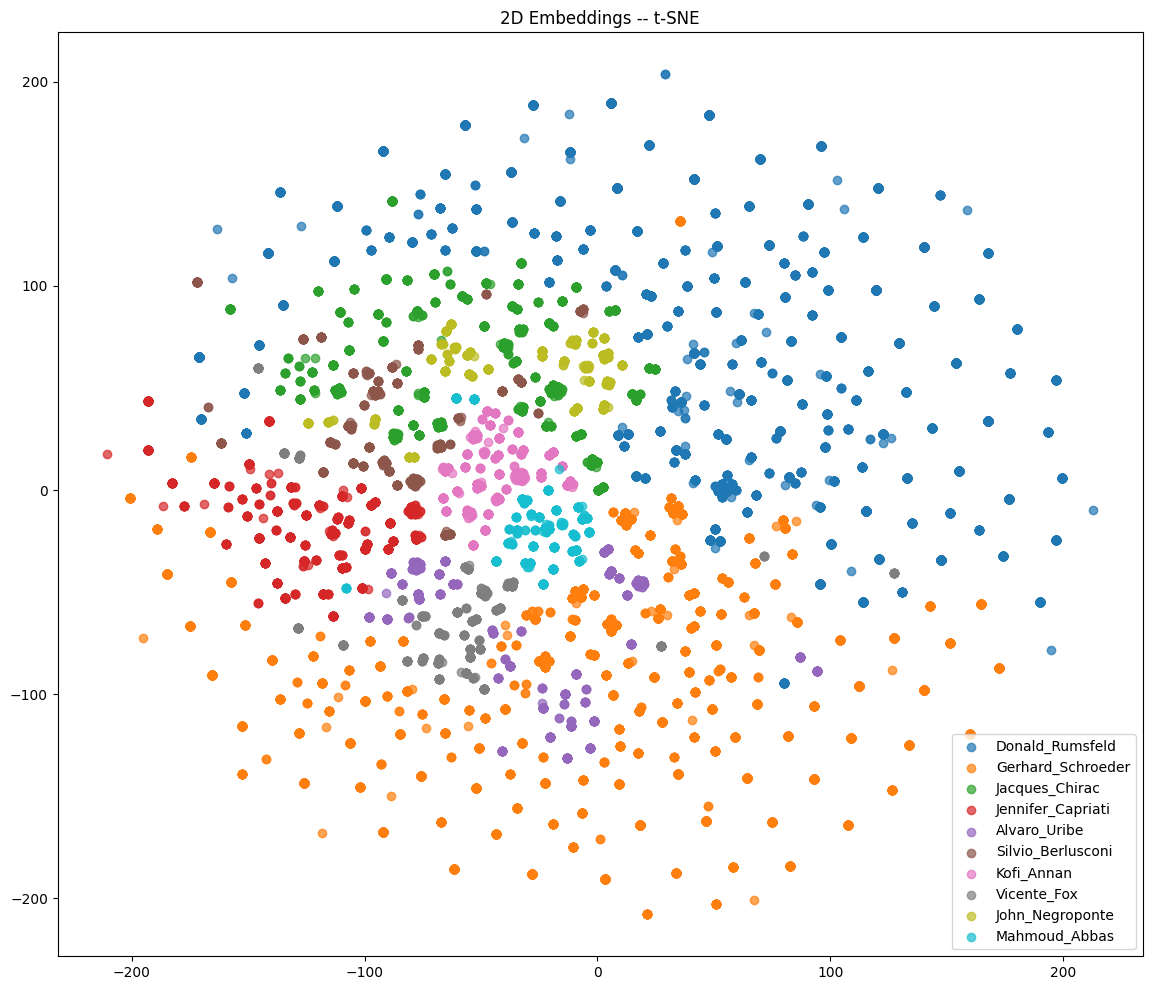

In [25]:
all_imgs, all_labels, label2id = gather_images_labels_topk(
        people_dict_test, top_k_people, transform=test_transform
    )
id2label = {i: person for person, i in label2id.items()}
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
visualize_embeddings_2D(embeddings, labels, method="tsne", id2label=id2label)

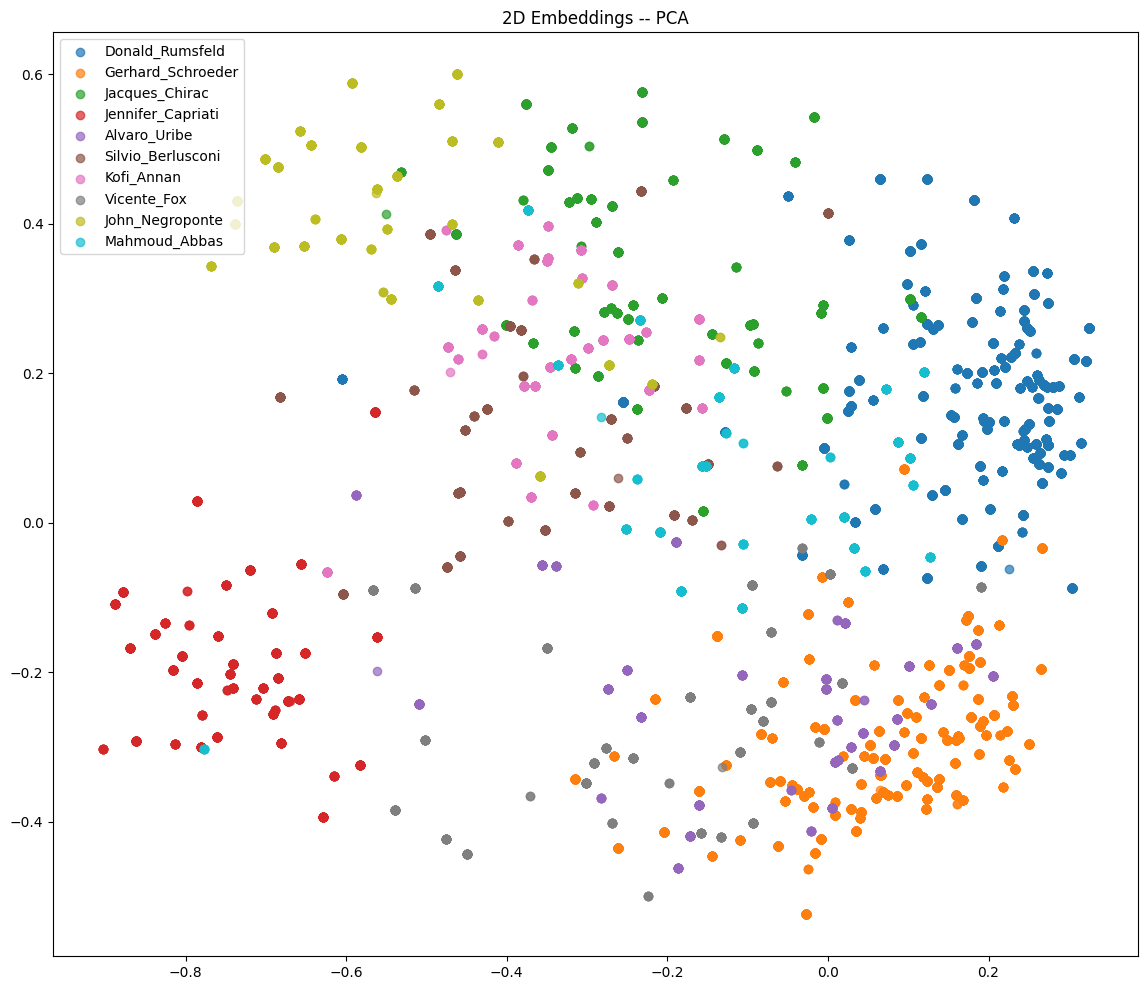

In [26]:
visualize_embeddings_2D(embeddings, labels, method="pca", id2label=id2label)

#### margin = 0.2

In [27]:
# Paramters
margin=0.2
epochs=50
project='trinet_model'
name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  2%|█                                                       | 1/50 [00:20<16:35, 20.32s/it]

Epoch [1/50] Train Loss: 0.0437 | Val Loss: 0.0362 | LR: 0.000100


  4%|██▏                                                     | 2/50 [00:40<16:08, 20.17s/it]

Epoch [2/50] Train Loss: 0.0223 | Val Loss: 0.0333 | LR: 0.000100


  6%|███▎                                                    | 3/50 [01:00<15:46, 20.14s/it]

Epoch [3/50] Train Loss: 0.0178 | Val Loss: 0.0316 | LR: 0.000100


  8%|████▍                                                   | 4/50 [01:20<15:25, 20.13s/it]

Epoch [4/50] Train Loss: 0.0151 | Val Loss: 0.0357 | LR: 0.000100


 10%|█████▌                                                  | 5/50 [01:40<15:03, 20.07s/it]

Epoch [5/50] Train Loss: 0.0137 | Val Loss: 0.0244 | LR: 0.000100


 12%|██████▋                                                 | 6/50 [02:00<14:40, 20.02s/it]

Epoch [6/50] Train Loss: 0.0124 | Val Loss: 0.0272 | LR: 0.000100


 14%|███████▊                                                | 7/50 [02:20<14:21, 20.03s/it]

Epoch [7/50] Train Loss: 0.0121 | Val Loss: 0.0251 | LR: 0.000100


 16%|████████▉                                               | 8/50 [02:40<14:04, 20.10s/it]

Epoch [8/50] Train Loss: 0.0109 | Val Loss: 0.0271 | LR: 0.000100


 18%|██████████                                              | 9/50 [03:00<13:44, 20.11s/it]

Epoch [9/50] Train Loss: 0.0099 | Val Loss: 0.0212 | LR: 0.000100


 20%|███████████                                            | 10/50 [03:21<13:23, 20.10s/it]

Epoch [10/50] Train Loss: 0.0100 | Val Loss: 0.0264 | LR: 0.000100


 22%|████████████                                           | 11/50 [03:41<13:02, 20.07s/it]

Epoch [11/50] Train Loss: 0.0101 | Val Loss: 0.0231 | LR: 0.000100


 24%|█████████████▏                                         | 12/50 [04:01<12:43, 20.09s/it]

Epoch [12/50] Train Loss: 0.0089 | Val Loss: 0.0253 | LR: 0.000100


 26%|██████████████▎                                        | 13/50 [04:21<12:24, 20.11s/it]

Epoch [13/50] Train Loss: 0.0081 | Val Loss: 0.0238 | LR: 0.000100


 28%|███████████████▍                                       | 14/50 [04:41<12:03, 20.10s/it]

Epoch [14/50] Train Loss: 0.0089 | Val Loss: 0.0215 | LR: 0.000100


 30%|████████████████▌                                      | 15/50 [05:05<12:21, 21.18s/it]

Epoch [15/50] Train Loss: 0.0084 | Val Loss: 0.0197 | LR: 0.000100


 32%|█████████████████▌                                     | 16/50 [05:25<11:56, 21.06s/it]

Epoch [16/50] Train Loss: 0.0087 | Val Loss: 0.0185 | LR: 0.000100


 34%|██████████████████▋                                    | 17/50 [05:45<11:24, 20.74s/it]

Epoch [17/50] Train Loss: 0.0074 | Val Loss: 0.0191 | LR: 0.000100


 36%|███████████████████▊                                   | 18/50 [06:05<10:56, 20.52s/it]

Epoch [18/50] Train Loss: 0.0071 | Val Loss: 0.0192 | LR: 0.000100


 38%|████████████████████▉                                  | 19/50 [06:25<10:32, 20.40s/it]

Epoch [19/50] Train Loss: 0.0064 | Val Loss: 0.0219 | LR: 0.000100


 40%|██████████████████████                                 | 20/50 [06:45<10:08, 20.28s/it]

Epoch [20/50] Train Loss: 0.0076 | Val Loss: 0.0177 | LR: 0.000100


 42%|███████████████████████                                | 21/50 [07:05<09:45, 20.20s/it]

Epoch [21/50] Train Loss: 0.0063 | Val Loss: 0.0242 | LR: 0.000100


 44%|████████████████████████▏                              | 22/50 [07:26<09:25, 20.21s/it]

Epoch [22/50] Train Loss: 0.0072 | Val Loss: 0.0207 | LR: 0.000100


 46%|█████████████████████████▎                             | 23/50 [07:46<09:03, 20.15s/it]

Epoch [23/50] Train Loss: 0.0063 | Val Loss: 0.0176 | LR: 0.000100


 48%|██████████████████████████▍                            | 24/50 [08:06<08:42, 20.10s/it]

Epoch [24/50] Train Loss: 0.0051 | Val Loss: 0.0172 | LR: 0.000100


 50%|███████████████████████████▌                           | 25/50 [08:26<08:22, 20.11s/it]

Epoch [25/50] Train Loss: 0.0053 | Val Loss: 0.0187 | LR: 0.000100


 52%|████████████████████████████▌                          | 26/50 [08:46<08:03, 20.14s/it]

Epoch [26/50] Train Loss: 0.0064 | Val Loss: 0.0212 | LR: 0.000100


 54%|█████████████████████████████▋                         | 27/50 [09:06<07:42, 20.12s/it]

Epoch [27/50] Train Loss: 0.0057 | Val Loss: 0.0200 | LR: 0.000100


 56%|██████████████████████████████▊                        | 28/50 [09:26<07:21, 20.08s/it]

Epoch [28/50] Train Loss: 0.0077 | Val Loss: 0.0208 | LR: 0.000100


 58%|███████████████████████████████▉                       | 29/50 [09:46<07:01, 20.08s/it]

Epoch [29/50] Train Loss: 0.0074 | Val Loss: 0.0203 | LR: 0.000100


 60%|█████████████████████████████████                      | 30/50 [10:06<06:40, 20.03s/it]

Epoch [30/50] Train Loss: 0.0054 | Val Loss: 0.0225 | LR: 0.000100


 62%|██████████████████████████████████                     | 31/50 [10:26<06:19, 19.98s/it]

Epoch [31/50] Train Loss: 0.0052 | Val Loss: 0.0181 | LR: 0.000100


 64%|███████████████████████████████████▏                   | 32/50 [10:46<05:59, 19.97s/it]

Epoch [32/50] Train Loss: 0.0051 | Val Loss: 0.0160 | LR: 0.000100


 66%|████████████████████████████████████▎                  | 33/50 [11:06<05:39, 19.97s/it]

Epoch [33/50] Train Loss: 0.0057 | Val Loss: 0.0150 | LR: 0.000100


 68%|█████████████████████████████████████▍                 | 34/50 [11:26<05:19, 19.99s/it]

Epoch [34/50] Train Loss: 0.0044 | Val Loss: 0.0178 | LR: 0.000100


 70%|██████████████████████████████████████▌                | 35/50 [11:46<04:59, 20.00s/it]

Epoch [35/50] Train Loss: 0.0065 | Val Loss: 0.0172 | LR: 0.000100


 72%|███████████████████████████████████████▌               | 36/50 [12:06<04:39, 19.99s/it]

Epoch [36/50] Train Loss: 0.0062 | Val Loss: 0.0163 | LR: 0.000100


 74%|████████████████████████████████████████▋              | 37/50 [12:26<04:19, 19.96s/it]

Epoch [37/50] Train Loss: 0.0047 | Val Loss: 0.0190 | LR: 0.000100


 76%|█████████████████████████████████████████▊             | 38/50 [12:46<04:01, 20.15s/it]

Epoch [38/50] Train Loss: 0.0052 | Val Loss: 0.0193 | LR: 0.000100


 78%|██████████████████████████████████████████▉            | 39/50 [13:06<03:40, 20.09s/it]

Epoch [39/50] Train Loss: 0.0053 | Val Loss: 0.0166 | LR: 0.000100


 80%|████████████████████████████████████████████           | 40/50 [13:26<03:21, 20.10s/it]

Epoch [40/50] Train Loss: 0.0044 | Val Loss: 0.0175 | LR: 0.000100


 82%|█████████████████████████████████████████████          | 41/50 [13:47<03:01, 20.11s/it]

Epoch [41/50] Train Loss: 0.0048 | Val Loss: 0.0197 | LR: 0.000100


 84%|██████████████████████████████████████████████▏        | 42/50 [14:07<02:41, 20.15s/it]

Epoch [42/50] Train Loss: 0.0060 | Val Loss: 0.0182 | LR: 0.000100


 86%|███████████████████████████████████████████████▎       | 43/50 [14:27<02:21, 20.17s/it]

Epoch [43/50] Train Loss: 0.0050 | Val Loss: 0.0171 | LR: 0.000100


 88%|████████████████████████████████████████████████▍      | 44/50 [14:47<02:00, 20.16s/it]

Epoch [44/50] Train Loss: 0.0046 | Val Loss: 0.0133 | LR: 0.000100


 90%|█████████████████████████████████████████████████▌     | 45/50 [15:07<01:40, 20.19s/it]

Epoch [45/50] Train Loss: 0.0046 | Val Loss: 0.0158 | LR: 0.000100


 92%|██████████████████████████████████████████████████▌    | 46/50 [15:28<01:20, 20.20s/it]

Epoch [46/50] Train Loss: 0.0047 | Val Loss: 0.0164 | LR: 0.000100


 94%|███████████████████████████████████████████████████▋   | 47/50 [15:48<01:00, 20.27s/it]

Epoch [47/50] Train Loss: 0.0059 | Val Loss: 0.0168 | LR: 0.000100


 96%|████████████████████████████████████████████████████▊  | 48/50 [16:08<00:40, 20.27s/it]

Epoch [48/50] Train Loss: 0.0043 | Val Loss: 0.0182 | LR: 0.000100


 98%|█████████████████████████████████████████████████████▉ | 49/50 [16:28<00:20, 20.22s/it]

Epoch [49/50] Train Loss: 0.0040 | Val Loss: 0.0183 | LR: 0.000100


100%|███████████████████████████████████████████████████████| 50/50 [16:49<00:00, 20.18s/it]

Epoch [50/50] Train Loss: 0.0051 | Val Loss: 0.0152 | LR: 0.000100


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▄▅▅▃▅▄▄▃▃▂▂▂▂▄▃▂▂▃▃▃▃▂▁▂▂▁▂▂▂▃▂▂▁▁▂▂▁
epoch,50
learning_rate,0.0001
train_loss,0.00511
val_loss,0.01517


Model saved at: ./saved_models/margin_0.2_ep_50


In [28]:
# Compute embeddings
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
ari_value = compute_ari_from_embeddings(embeddings, labels, device)
print(f"Adjusted Rand Index (ARI): {ari_value:.4f}")

Adjusted Rand Index (ARI): 0.4363


#### margin=0.5

In [29]:
# Paramters
margin=0.5
epochs=50
project='trinet_model'
name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  2%|█                                                       | 1/50 [00:20<16:34, 20.30s/it]

Epoch [1/50] Train Loss: 0.1467 | Val Loss: 0.1116 | LR: 0.000100


  4%|██▏                                                     | 2/50 [00:40<16:14, 20.29s/it]

Epoch [2/50] Train Loss: 0.0761 | Val Loss: 0.0934 | LR: 0.000100


  6%|███▎                                                    | 3/50 [01:00<15:50, 20.23s/it]

Epoch [3/50] Train Loss: 0.0596 | Val Loss: 0.0837 | LR: 0.000100


  8%|████▍                                                   | 4/50 [01:20<15:30, 20.22s/it]

Epoch [4/50] Train Loss: 0.0525 | Val Loss: 0.0818 | LR: 0.000100


 10%|█████▌                                                  | 5/50 [01:41<15:08, 20.20s/it]

Epoch [5/50] Train Loss: 0.0424 | Val Loss: 0.0763 | LR: 0.000100


 12%|██████▋                                                 | 6/50 [02:01<14:48, 20.20s/it]

Epoch [6/50] Train Loss: 0.0374 | Val Loss: 0.0759 | LR: 0.000100


 14%|███████▊                                                | 7/50 [02:21<14:29, 20.23s/it]

Epoch [7/50] Train Loss: 0.0355 | Val Loss: 0.0713 | LR: 0.000100


 16%|████████▉                                               | 8/50 [02:41<14:09, 20.22s/it]

Epoch [8/50] Train Loss: 0.0325 | Val Loss: 0.0644 | LR: 0.000100


 18%|██████████                                              | 9/50 [03:01<13:46, 20.17s/it]

Epoch [9/50] Train Loss: 0.0305 | Val Loss: 0.0723 | LR: 0.000100


 20%|███████████                                            | 10/50 [03:22<13:27, 20.18s/it]

Epoch [10/50] Train Loss: 0.0309 | Val Loss: 0.0636 | LR: 0.000100


 22%|████████████                                           | 11/50 [03:42<13:06, 20.17s/it]

Epoch [11/50] Train Loss: 0.0310 | Val Loss: 0.0613 | LR: 0.000100


 24%|█████████████▏                                         | 12/50 [04:02<12:45, 20.14s/it]

Epoch [12/50] Train Loss: 0.0263 | Val Loss: 0.0620 | LR: 0.000100


 26%|██████████████▎                                        | 13/50 [04:22<12:26, 20.18s/it]

Epoch [13/50] Train Loss: 0.0282 | Val Loss: 0.0641 | LR: 0.000100


 28%|███████████████▍                                       | 14/50 [04:42<12:07, 20.20s/it]

Epoch [14/50] Train Loss: 0.0263 | Val Loss: 0.0669 | LR: 0.000100


 30%|████████████████▌                                      | 15/50 [05:02<11:46, 20.18s/it]

Epoch [15/50] Train Loss: 0.0240 | Val Loss: 0.0561 | LR: 0.000100


 32%|█████████████████▌                                     | 16/50 [05:23<11:26, 20.19s/it]

Epoch [16/50] Train Loss: 0.0228 | Val Loss: 0.0597 | LR: 0.000100


 34%|██████████████████▋                                    | 17/50 [05:43<11:06, 20.19s/it]

Epoch [17/50] Train Loss: 0.0219 | Val Loss: 0.0577 | LR: 0.000100


 36%|███████████████████▊                                   | 18/50 [06:03<10:45, 20.18s/it]

Epoch [18/50] Train Loss: 0.0237 | Val Loss: 0.0587 | LR: 0.000100


 38%|████████████████████▉                                  | 19/50 [06:23<10:25, 20.18s/it]

Epoch [19/50] Train Loss: 0.0213 | Val Loss: 0.0640 | LR: 0.000100


 40%|██████████████████████                                 | 20/50 [06:43<10:06, 20.20s/it]

Epoch [20/50] Train Loss: 0.0202 | Val Loss: 0.0707 | LR: 0.000100


 42%|███████████████████████                                | 21/50 [07:04<09:46, 20.24s/it]

Epoch [21/50] Train Loss: 0.0189 | Val Loss: 0.0625 | LR: 0.000100


 44%|████████████████████████▏                              | 22/50 [07:24<09:26, 20.25s/it]

Epoch [22/50] Train Loss: 0.0186 | Val Loss: 0.0535 | LR: 0.000100


 46%|█████████████████████████▎                             | 23/50 [07:44<09:06, 20.23s/it]

Epoch [23/50] Train Loss: 0.0186 | Val Loss: 0.0597 | LR: 0.000100


 48%|██████████████████████████▍                            | 24/50 [08:05<08:46, 20.26s/it]

Epoch [24/50] Train Loss: 0.0188 | Val Loss: 0.0716 | LR: 0.000100


 50%|███████████████████████████▌                           | 25/50 [08:25<08:26, 20.27s/it]

Epoch [25/50] Train Loss: 0.0162 | Val Loss: 0.0614 | LR: 0.000100


 52%|████████████████████████████▌                          | 26/50 [08:45<08:06, 20.26s/it]

Epoch [26/50] Train Loss: 0.0191 | Val Loss: 0.0669 | LR: 0.000100


 54%|█████████████████████████████▋                         | 27/50 [09:05<07:45, 20.25s/it]

Epoch [27/50] Train Loss: 0.0167 | Val Loss: 0.0634 | LR: 0.000100


 56%|██████████████████████████████▊                        | 28/50 [09:25<07:24, 20.22s/it]

Epoch [28/50] Train Loss: 0.0168 | Val Loss: 0.0584 | LR: 0.000100


 58%|███████████████████████████████▉                       | 29/50 [09:46<07:05, 20.26s/it]

Epoch [29/50] Train Loss: 0.0176 | Val Loss: 0.0548 | LR: 0.000100


 60%|█████████████████████████████████                      | 30/50 [10:10<07:06, 21.32s/it]

Epoch [30/50] Train Loss: 0.0163 | Val Loss: 0.0681 | LR: 0.000100


 62%|██████████████████████████████████                     | 31/50 [10:30<06:37, 20.95s/it]

Epoch [31/50] Train Loss: 0.0154 | Val Loss: 0.0612 | LR: 0.000100


 64%|███████████████████████████████████▏                   | 32/50 [10:50<06:12, 20.69s/it]

Epoch [32/50] Train Loss: 0.0147 | Val Loss: 0.0561 | LR: 0.000100


 66%|████████████████████████████████████▎                  | 33/50 [11:10<05:48, 20.51s/it]

Epoch [33/50] Train Loss: 0.0144 | Val Loss: 0.0535 | LR: 0.000100


 68%|█████████████████████████████████████▍                 | 34/50 [11:30<05:25, 20.35s/it]

Epoch [34/50] Train Loss: 0.0150 | Val Loss: 0.0514 | LR: 0.000100


 70%|██████████████████████████████████████▌                | 35/50 [11:50<05:05, 20.33s/it]

Epoch [35/50] Train Loss: 0.0131 | Val Loss: 0.0512 | LR: 0.000100


 72%|███████████████████████████████████████▌               | 36/50 [12:10<04:44, 20.30s/it]

Epoch [36/50] Train Loss: 0.0141 | Val Loss: 0.0617 | LR: 0.000100


 74%|████████████████████████████████████████▋              | 37/50 [12:31<04:24, 20.36s/it]

Epoch [37/50] Train Loss: 0.0160 | Val Loss: 0.0597 | LR: 0.000100


 76%|█████████████████████████████████████████▊             | 38/50 [12:51<04:04, 20.38s/it]

Epoch [38/50] Train Loss: 0.0168 | Val Loss: 0.0589 | LR: 0.000100


 78%|██████████████████████████████████████████▉            | 39/50 [13:11<03:43, 20.31s/it]

Epoch [39/50] Train Loss: 0.0141 | Val Loss: 0.0557 | LR: 0.000100


 80%|████████████████████████████████████████████           | 40/50 [13:32<03:23, 20.30s/it]

Epoch [40/50] Train Loss: 0.0152 | Val Loss: 0.0593 | LR: 0.000100


 82%|█████████████████████████████████████████████          | 41/50 [13:52<03:02, 20.28s/it]

Epoch [41/50] Train Loss: 0.0156 | Val Loss: 0.0552 | LR: 0.000100


 84%|██████████████████████████████████████████████▏        | 42/50 [14:12<02:42, 20.30s/it]

Epoch [42/50] Train Loss: 0.0134 | Val Loss: 0.0588 | LR: 0.000100


 86%|███████████████████████████████████████████████▎       | 43/50 [14:33<02:22, 20.30s/it]

Epoch [43/50] Train Loss: 0.0132 | Val Loss: 0.0590 | LR: 0.000100


 88%|████████████████████████████████████████████████▍      | 44/50 [14:53<02:01, 20.29s/it]

Epoch [44/50] Train Loss: 0.0121 | Val Loss: 0.0568 | LR: 0.000100


 90%|█████████████████████████████████████████████████▌     | 45/50 [15:13<01:41, 20.28s/it]

Epoch [45/50] Train Loss: 0.0127 | Val Loss: 0.0577 | LR: 0.000100


 92%|██████████████████████████████████████████████████▌    | 46/50 [15:33<01:20, 20.24s/it]

Epoch [46/50] Train Loss: 0.0134 | Val Loss: 0.0578 | LR: 0.000100


 94%|███████████████████████████████████████████████████▋   | 47/50 [15:54<01:00, 20.25s/it]

Epoch [47/50] Train Loss: 0.0101 | Val Loss: 0.0521 | LR: 0.000100


 96%|████████████████████████████████████████████████████▊  | 48/50 [16:14<00:40, 20.22s/it]

Epoch [48/50] Train Loss: 0.0123 | Val Loss: 0.0689 | LR: 0.000100


 98%|█████████████████████████████████████████████████████▉ | 49/50 [16:34<00:20, 20.21s/it]

Epoch [49/50] Train Loss: 0.0124 | Val Loss: 0.0640 | LR: 0.000100


100%|███████████████████████████████████████████████████████| 50/50 [16:54<00:00, 20.29s/it]

Epoch [50/50] Train Loss: 0.0125 | Val Loss: 0.0596 | LR: 0.000100


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▂▂▂▃▂▂▂▂▃▁▂▃▃▂▂▁▃▂▁▁▁▂▂▂▂▁▂▂▂▂▁▂
epoch,50
learning_rate,0.0001
train_loss,0.01249
val_loss,0.05962


Model saved at: ./saved_models/margin_0.5_ep_50


In [30]:
# Compute embeddings
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
ari_value = compute_ari_from_embeddings(embeddings, labels, device)
print(f"Adjusted Rand Index (ARI): {ari_value:.4f}")

Adjusted Rand Index (ARI): 0.4117


#### margin = 1.0

In [20]:
# Paramters
margin=1.0
epochs=50
project='trinet_model'
name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  2%|█                                                       | 1/50 [00:20<16:48, 20.57s/it]

Epoch [1/50] Train Loss: 0.4143 | Val Loss: 0.3224 | LR: 0.000100


  4%|██▏                                                     | 2/50 [00:40<16:08, 20.17s/it]

Epoch [2/50] Train Loss: 0.2490 | Val Loss: 0.2681 | LR: 0.000100


  6%|███▎                                                    | 3/50 [01:00<15:41, 20.04s/it]

Epoch [3/50] Train Loss: 0.2186 | Val Loss: 0.2672 | LR: 0.000100


  8%|████▍                                                   | 4/50 [01:20<15:23, 20.09s/it]

Epoch [4/50] Train Loss: 0.1932 | Val Loss: 0.2559 | LR: 0.000100


 10%|█████▌                                                  | 5/50 [01:40<15:04, 20.10s/it]

Epoch [5/50] Train Loss: 0.1754 | Val Loss: 0.2364 | LR: 0.000100


 12%|██████▋                                                 | 6/50 [02:00<14:44, 20.11s/it]

Epoch [6/50] Train Loss: 0.1547 | Val Loss: 0.2465 | LR: 0.000100


 14%|███████▊                                                | 7/50 [02:20<14:23, 20.08s/it]

Epoch [7/50] Train Loss: 0.1479 | Val Loss: 0.2240 | LR: 0.000100


 16%|████████▉                                               | 8/50 [02:40<14:02, 20.07s/it]

Epoch [8/50] Train Loss: 0.1483 | Val Loss: 0.2305 | LR: 0.000100


 18%|██████████                                              | 9/50 [03:01<13:44, 20.11s/it]

Epoch [9/50] Train Loss: 0.1363 | Val Loss: 0.2250 | LR: 0.000100


 20%|███████████                                            | 10/50 [03:21<13:27, 20.19s/it]

Epoch [10/50] Train Loss: 0.1353 | Val Loss: 0.2203 | LR: 0.000100


 22%|████████████                                           | 11/50 [03:45<13:51, 21.32s/it]

Epoch [11/50] Train Loss: 0.1275 | Val Loss: 0.2183 | LR: 0.000100


 24%|█████████████▏                                         | 12/50 [04:07<13:41, 21.62s/it]

Epoch [12/50] Train Loss: 0.1259 | Val Loss: 0.2223 | LR: 0.000100


 26%|██████████████▎                                        | 13/50 [04:57<18:39, 30.25s/it]

Epoch [13/50] Train Loss: 0.1165 | Val Loss: 0.2149 | LR: 0.000100


 28%|███████████████▍                                       | 14/50 [05:17<16:16, 27.13s/it]

Epoch [14/50] Train Loss: 0.1117 | Val Loss: 0.2088 | LR: 0.000100


 30%|████████████████▌                                      | 15/50 [05:37<14:33, 24.96s/it]

Epoch [15/50] Train Loss: 0.1098 | Val Loss: 0.2101 | LR: 0.000100


 32%|█████████████████▌                                     | 16/50 [05:57<13:16, 23.44s/it]

Epoch [16/50] Train Loss: 0.1044 | Val Loss: 0.2108 | LR: 0.000100


 34%|██████████████████▋                                    | 17/50 [06:17<12:21, 22.48s/it]

Epoch [17/50] Train Loss: 0.1028 | Val Loss: 0.2054 | LR: 0.000100


 36%|███████████████████▊                                   | 18/50 [06:37<11:37, 21.78s/it]

Epoch [18/50] Train Loss: 0.0969 | Val Loss: 0.2208 | LR: 0.000100


 38%|████████████████████▉                                  | 19/50 [06:57<10:57, 21.21s/it]

Epoch [19/50] Train Loss: 0.1057 | Val Loss: 0.2055 | LR: 0.000100


 40%|██████████████████████                                 | 20/50 [07:17<10:25, 20.84s/it]

Epoch [20/50] Train Loss: 0.0988 | Val Loss: 0.2113 | LR: 0.000100


 42%|███████████████████████                                | 21/50 [07:37<09:58, 20.63s/it]

Epoch [21/50] Train Loss: 0.0984 | Val Loss: 0.2198 | LR: 0.000100


 44%|████████████████████████▏                              | 22/50 [07:57<09:33, 20.46s/it]

Epoch [22/50] Train Loss: 0.0934 | Val Loss: 0.2092 | LR: 0.000100


 46%|█████████████████████████▎                             | 23/50 [08:18<09:09, 20.35s/it]

Epoch [23/50] Train Loss: 0.0862 | Val Loss: 0.2150 | LR: 0.000100


 48%|██████████████████████████▍                            | 24/50 [08:38<08:47, 20.28s/it]

Epoch [24/50] Train Loss: 0.0930 | Val Loss: 0.2060 | LR: 0.000100


 50%|███████████████████████████▌                           | 25/50 [08:58<08:24, 20.19s/it]

Epoch [25/50] Train Loss: 0.0798 | Val Loss: 0.2009 | LR: 0.000100


 52%|████████████████████████████▌                          | 26/50 [09:18<08:03, 20.14s/it]

Epoch [26/50] Train Loss: 0.0822 | Val Loss: 0.2095 | LR: 0.000100


 54%|█████████████████████████████▋                         | 27/50 [09:38<07:43, 20.14s/it]

Epoch [27/50] Train Loss: 0.0876 | Val Loss: 0.2100 | LR: 0.000100


 56%|██████████████████████████████▊                        | 28/50 [09:58<07:22, 20.11s/it]

Epoch [28/50] Train Loss: 0.0821 | Val Loss: 0.2147 | LR: 0.000100


 58%|███████████████████████████████▉                       | 29/50 [10:18<07:04, 20.21s/it]

Epoch [29/50] Train Loss: 0.0795 | Val Loss: 0.2176 | LR: 0.000100


 60%|█████████████████████████████████                      | 30/50 [10:39<06:46, 20.31s/it]

Epoch [30/50] Train Loss: 0.0822 | Val Loss: 0.1912 | LR: 0.000100


 62%|██████████████████████████████████                     | 31/50 [10:59<06:24, 20.24s/it]

Epoch [31/50] Train Loss: 0.0788 | Val Loss: 0.2211 | LR: 0.000100


 64%|███████████████████████████████████▏                   | 32/50 [11:19<06:03, 20.20s/it]

Epoch [32/50] Train Loss: 0.0788 | Val Loss: 0.2031 | LR: 0.000100


 66%|████████████████████████████████████▎                  | 33/50 [11:39<05:42, 20.15s/it]

Epoch [33/50] Train Loss: 0.0770 | Val Loss: 0.2256 | LR: 0.000100


 68%|█████████████████████████████████████▍                 | 34/50 [11:59<05:22, 20.13s/it]

Epoch [34/50] Train Loss: 0.0663 | Val Loss: 0.2122 | LR: 0.000100


 70%|██████████████████████████████████████▌                | 35/50 [12:19<05:01, 20.09s/it]

Epoch [35/50] Train Loss: 0.0750 | Val Loss: 0.2122 | LR: 0.000100


 72%|███████████████████████████████████████▌               | 36/50 [12:39<04:40, 20.04s/it]

Epoch [36/50] Train Loss: 0.0718 | Val Loss: 0.2189 | LR: 0.000100


 74%|████████████████████████████████████████▋              | 37/50 [12:59<04:20, 20.04s/it]

Epoch [37/50] Train Loss: 0.0732 | Val Loss: 0.2196 | LR: 0.000100


 76%|█████████████████████████████████████████▊             | 38/50 [13:19<04:00, 20.02s/it]

Epoch [38/50] Train Loss: 0.0694 | Val Loss: 0.2222 | LR: 0.000100


 78%|██████████████████████████████████████████▉            | 39/50 [13:39<03:39, 20.00s/it]

Epoch [39/50] Train Loss: 0.0686 | Val Loss: 0.2243 | LR: 0.000100


 80%|████████████████████████████████████████████           | 40/50 [13:59<03:20, 20.02s/it]

Epoch [40/50] Train Loss: 0.0692 | Val Loss: 0.2305 | LR: 0.000100


 82%|█████████████████████████████████████████████          | 41/50 [14:19<03:00, 20.01s/it]

Epoch [41/50] Train Loss: 0.0665 | Val Loss: 0.2170 | LR: 0.000100


 84%|██████████████████████████████████████████████▏        | 42/50 [14:39<02:39, 19.98s/it]

Epoch [42/50] Train Loss: 0.0690 | Val Loss: 0.2105 | LR: 0.000100


 86%|███████████████████████████████████████████████▎       | 43/50 [14:59<02:19, 19.98s/it]

Epoch [43/50] Train Loss: 0.0632 | Val Loss: 0.2013 | LR: 0.000100


 88%|████████████████████████████████████████████████▍      | 44/50 [15:19<01:59, 19.96s/it]

Epoch [44/50] Train Loss: 0.0642 | Val Loss: 0.2191 | LR: 0.000100


 90%|█████████████████████████████████████████████████▌     | 45/50 [15:39<01:39, 19.96s/it]

Epoch [45/50] Train Loss: 0.0645 | Val Loss: 0.2173 | LR: 0.000100


 92%|██████████████████████████████████████████████████▌    | 46/50 [15:59<01:19, 19.96s/it]

Epoch [46/50] Train Loss: 0.0615 | Val Loss: 0.2128 | LR: 0.000100


 94%|███████████████████████████████████████████████████▋   | 47/50 [16:19<00:59, 19.97s/it]

Epoch [47/50] Train Loss: 0.0645 | Val Loss: 0.2282 | LR: 0.000100


 96%|████████████████████████████████████████████████████▊  | 48/50 [16:39<00:39, 19.98s/it]

Epoch [48/50] Train Loss: 0.0581 | Val Loss: 0.2131 | LR: 0.000100


 98%|█████████████████████████████████████████████████████▉ | 49/50 [16:59<00:20, 20.01s/it]

Epoch [49/50] Train Loss: 0.0580 | Val Loss: 0.2219 | LR: 0.000100


100%|███████████████████████████████████████████████████████| 50/50 [17:19<00:00, 20.79s/it]

Epoch [50/50] Train Loss: 0.0622 | Val Loss: 0.2322 | LR: 0.000100


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▃▂▂▂▂▂▃▂▃▂▂▂▂▂▂▁▃▃▂▂▂▃▃▃▂▂▂▂▂▃▂▃
epoch,50
learning_rate,0.0001
train_loss,0.0622
val_loss,0.23221


Model saved at: ./saved_models/margin_1.0_ep_50


In [24]:
# Compute embeddings
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
ari_value = compute_ari_from_embeddings(embeddings, labels, device)
print(f"Adjusted Rand Index (ARI): {ari_value:.4f}")

Adjusted Rand Index (ARI): 0.4117


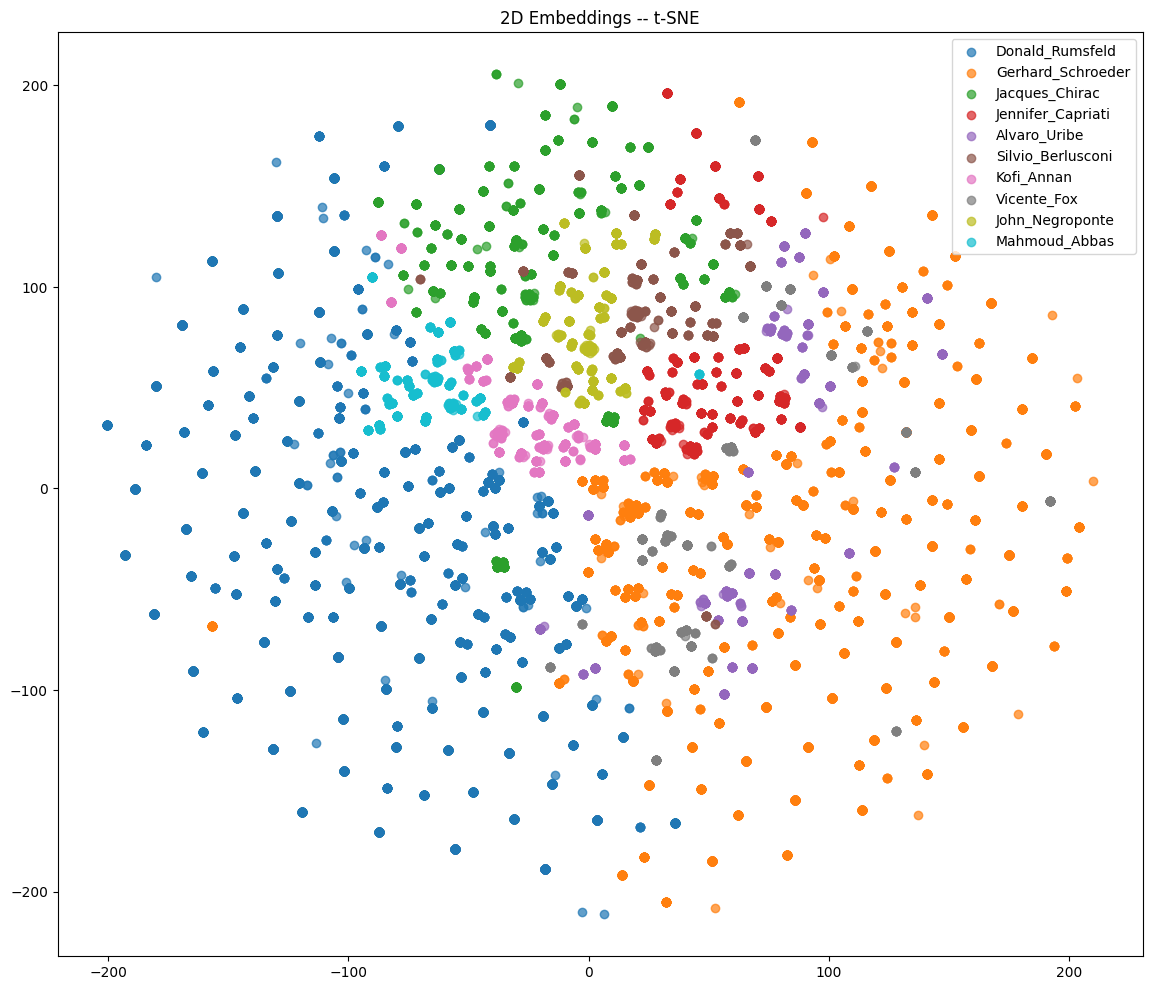

In [25]:
all_imgs, all_labels, label2id = gather_images_labels_topk(
        people_dict_test, top_k_people, transform=test_transform
    )
id2label = {i: person for person, i in label2id.items()}
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
visualize_embeddings_2D(embeddings, labels, method="tsne", id2label=id2label)

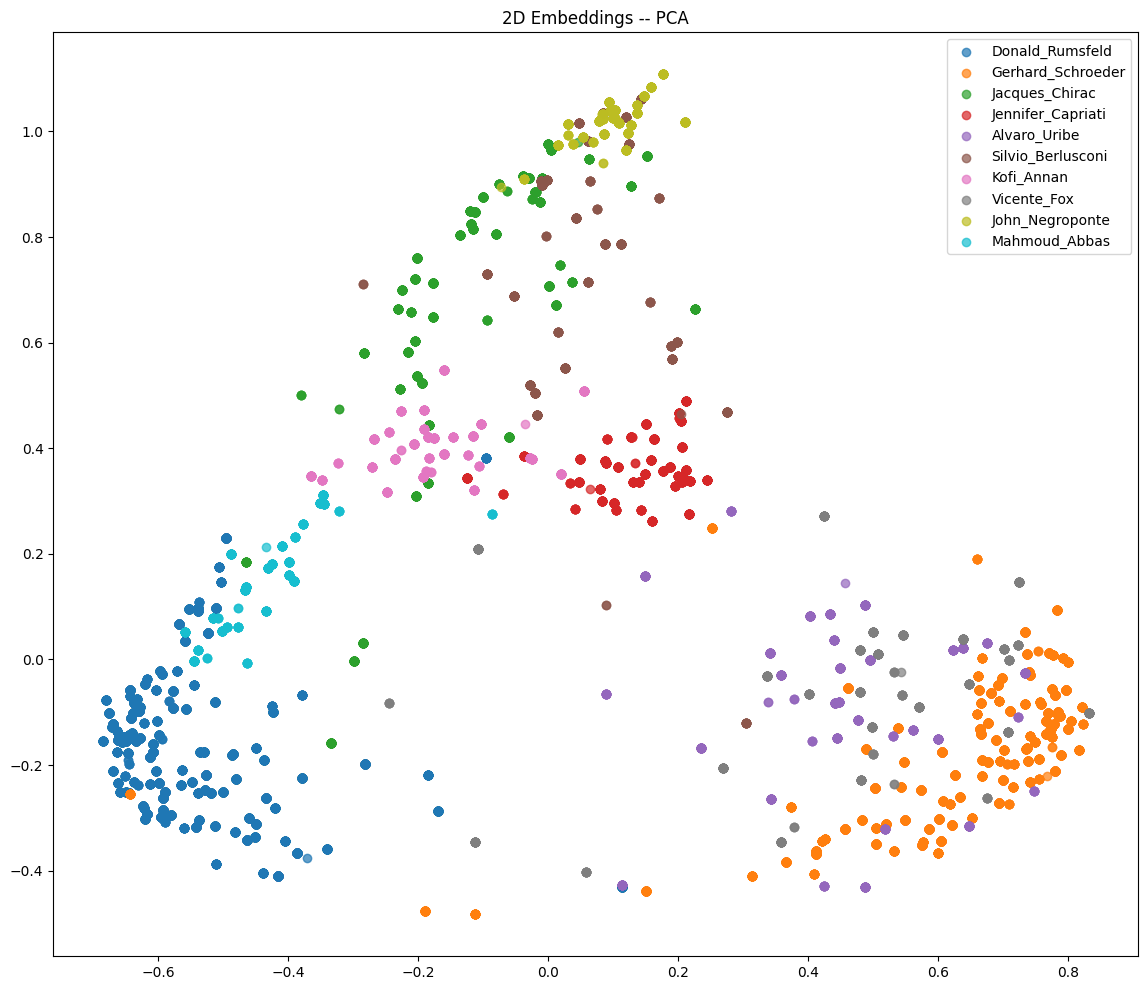

In [26]:
visualize_embeddings_2D(embeddings, labels, method="pca", id2label=id2label)